# Trabalho 4 - Operações Geométricas

## Preâmbulo

Uma operação geométrica produz uma nova imagem modificando as relações geométricas dos pixels da imagem original.
Esta tem como base dois modelos matemáticos:
* Transformação geométrica $T: (x, y) \in \mathbb{U} \rightarrow (u, v) \in \mathbb{U}'$
* Reconstrução $f'(x, y) = \sum_{\forall(x_i, y_i) \in \mathbb{U}} f(x_i, y_i)\Phi(x - x_i, y - y_i)$

Vale notar que a reconstrução da imagem contínua original não é exata: $f'(x,y) \ne f(x,y)$

Existem alguns tipos de transformações básicas, sendo elas:
* Euclidiana: preserva a distância Euclidiana
  * Identidade
$$
\begin{vmatrix} 
u \\
v \\
1
\end{vmatrix}
=
\begin{vmatrix} 
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{vmatrix}
\begin{vmatrix} 
x \\
y \\
1
\end{vmatrix}
$$
  * Translação
$$
\begin{vmatrix} 
u \\
v \\
1
\end{vmatrix}
=
\begin{vmatrix} 
1 & 0 & c \\
0 & 1 & f \\
0 & 0 & 1 
\end{vmatrix}
\begin{vmatrix} 
x \\
y \\
1
\end{vmatrix}
$$
  * Rotação
$$
\begin{vmatrix} 
u \\
v \\
1
\end{vmatrix}
=
\begin{vmatrix} 
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 
\end{vmatrix}
\begin{vmatrix} 
x \\
y \\
1
\end{vmatrix}
$$
  * Euclidiana geral
$$
\begin{vmatrix} 
u \\
v \\
1
\end{vmatrix}
=
\begin{vmatrix} 
a & b & c \\
d & e & f \\
0 & 0 & 1 
\end{vmatrix}
\begin{vmatrix} 
x \\
y \\
1
\end{vmatrix}
$$
Onde $\begin{vmatrix} a & b \\ d & e \end{vmatrix}$ é ortogonal.
* Afim: preserva o paralelismo
  * Afim geral
$$
\begin{vmatrix} 
u \\
v \\
1
\end{vmatrix}
=
\begin{vmatrix} 
a & b & c \\
d & e & f \\
0 & 0 & 1 
\end{vmatrix}
\begin{vmatrix} 
x \\
y \\
1
\end{vmatrix}
$$
  * Escala
$$
\begin{vmatrix} 
u \\
v \\
1
\end{vmatrix}
=
\begin{vmatrix} 
a & 0 & 0 \\
0 & e & 0 \\
0 & 0 & 1 
\end{vmatrix}
\begin{vmatrix} 
x \\
y \\
1
\end{vmatrix}
$$
  * Cisalhamento
    * Horizontal
$$
\begin{vmatrix} 
u \\
v \\
1
\end{vmatrix}
=
\begin{vmatrix} 
1 & 0 & 0 \\
d & 1 & 0 \\
0 & 0 & 1 
\end{vmatrix}
\begin{vmatrix} 
x \\
y \\
1
\end{vmatrix}
$$
    * Vertical
$$
\begin{vmatrix} 
u \\
v \\
1
\end{vmatrix}
=
\begin{vmatrix} 
1 & b & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{vmatrix}
\begin{vmatrix} 
x \\
y \\
1
\end{vmatrix}
$$
* Projetiva: preserva a colineariedade
  * Projetiva geral
$$
\begin{vmatrix} 
u \\
v \\
s
\end{vmatrix}
=
\begin{vmatrix} 
a & b & c \\
d & e & f \\
g & h & 1 
\end{vmatrix}
\begin{vmatrix} 
x \\
y \\
w
\end{vmatrix}
$$



## Código

O código, apresentado a seguir, é separado nos métodos:
* minimos_quadrados - faz o cálculo do método dos mínimos quadrados;
* transformar_coordenadas - transforma as coordenadas da imagem original conforme a matriz de transformação informada;
* image_side_by_side - plota duas imagens lado a lado.

Criou-se uma enumeração _PointMethod_ apenas para diferenciar o método de cálculo do valor dos pontos, que pode ser __NEAREST_NEIGHBOR__ que corresponde ao vizinho mais próximo ou __NEIGHBORHOOD_AVG__ que corresponde a média dos pontos na vizinhança.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from enum import Enum

np.seterr(all='raise')


def minimos_quadrados(xy, uv):
	A = np.zeros([2 * xy.shape[0], 8])
	L = np.zeros([2 * xy.shape[0], 1])

	for i in range(xy.shape[0]):
		A[2 * i, 0], A[2 * i, 1], A[2 * i, 2] = xy[i][0], xy[i][1], 1
		A[2 * i, 6], A[2 * i, 7] = -xy[i][0] * uv[i][0], - xy[i][1] * uv[i][0]

		A[2 * i + 1, 3], A[2 * i + 1, 4], A[2 * i + 1, 5] = xy[i][0], xy[i][1], 1
		A[2 * i + 1, 6], A[2 * i + 1, 7] = -xy[i][0] * uv[i][1], - xy[i][1] * uv[i][1]

		L[2 * i], L[2 * i + 1] = uv[i, 0], uv[i, 1]

	A_t = A.transpose()
	A_tA_inv = np.linalg.inv(np.matmul(A_t, A))
	X_chapeu = np.matmul(np.matmul(A_tA_inv, A_t), L)

	T = np.ones([3, 3])
	T[0, 0], T[0, 1], T[0, 2] = X_chapeu[0], X_chapeu[1], X_chapeu[2]
	T[1, 0], T[1, 1], T[1, 2] = X_chapeu[3], X_chapeu[4], X_chapeu[5]
	T[2, 0], T[2, 1] = X_chapeu[6], X_chapeu[7]
	return T


file_name = "storm_trooper.jpg"
storm_img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
height, width = storm_img.shape

print("Storm Trooper")
xy = np.array([[107, 526], [226, 1410], [1311, 1248], [1074, 32]])
uv = np.array([(0, 0), (0, width), (width, height), (height, 0)])
transformation = minimos_quadrados(xy, uv)
print(transformation)


class PointMethod(Enum):
	NEAREST_NEIGHBOR = 1
	NEIGHBORHOOD_AVG = 2


def transformar_coordenadas(img, t, method=PointMethod.NEAREST_NEIGHBOR):
	resp = np.zeros((height, width), np.uint8)
	t = np.linalg.inv(t)

	for x in range(height - 1):
		for y in range(width - 1):
			x_chapeu = np.dot(t, np.array([x, y, 1]))
			x_chapeu /= x_chapeu[2]

			xv = [math.floor(x_chapeu[0]), math.ceil(x_chapeu[0])]
			yv = [math.floor(x_chapeu[1]), math.floor(x_chapeu[1])]
			points = [(i, j) for i in xv for j in yv]
			dists = [math.hypot(x_chapeu[0] - x_chapeu[1], it[0] - it[1]) for it in points]

			if method == PointMethod.NEAREST_NEIGHBOR:
				idx = np.argmin(dists)
				resp[x, y] = img[points[idx][0], points[idx][1]]
			elif method == PointMethod.NEIGHBORHOOD_AVG:
				value = 0
				for i in range(len(points)):
					value += img[points[i][0], points[i][1]] * dists[i]
				resp[x, y] = np.uint8(value // sum(dists))

	return resp


def image_side_by_side(imgs, titles, x_zoom=None, y_zoom=None):
	plt.subplot(121), plt.imshow(imgs[0], cmap='gray'), plt.title(titles[0])
	if x_zoom:
		plt.xlim(x_zoom[0], x_zoom[1])
	if y_zoom:
		plt.ylim(y_zoom[0], y_zoom[1])
	plt.subplot(122), plt.imshow(imgs[1], cmap='gray'), plt.title(titles[1])
	if x_zoom:
		plt.xlim(x_zoom[0], x_zoom[1])
	if y_zoom:
		plt.ylim(y_zoom[0], y_zoom[1])
	plt.show()

Storm Trooper
[[ 2.03869893e+00 -2.74440240e-01 -7.37852189e+01]
 [ 8.57388529e-01  1.67832937e+00 -9.74541820e+02]
 [ 4.23892198e-04 -4.77937991e-06  1.00000000e+00]]


## Resultados

Para os testes foi utilizada a imagem fornecida na descrição do trabalho.

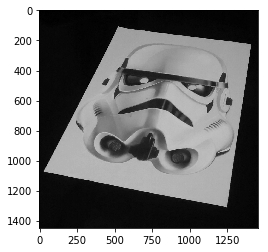

(1448, 1456)


In [2]:
plt.imshow(storm_img, cmap='gray', vmin=0, vmax=255)
plt.show()
print(storm_img.shape)

Primeiramente é gerada a imagem utilizando o método __NEAREST_NEIGHBOR__, esta é exibida e é contabilizado o tempo para execução de tal método.

Elapsed time: 72.39881420135498s, size: (1448, 1456)


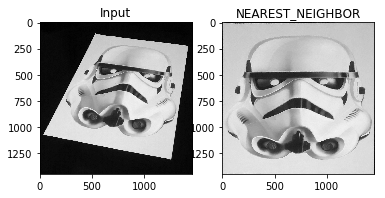

In [3]:
start = time.time()
resp = transformar_coordenadas(storm_img, transformation, PointMethod.NEAREST_NEIGHBOR)
end = time.time()
print(f"Elapsed time: {end - start:3}s, size: {resp.shape}")
image_side_by_side([storm_img, resp], ['Input', 'NEAREST_NEIGHBOR'])

Logo em seguida é gerada a imagem utilizando o método __NEIGHBORHOOD_AVG__, esta é exibida e é contabilizado o tempo para execução de tal método.

Elapsed time: 104.12653017044067s, size: (1448, 1456)


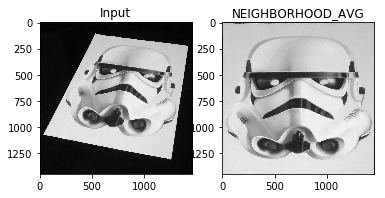

In [4]:
start = time.time()
resp_avg = transformar_coordenadas(storm_img, transformation, PointMethod.NEIGHBORHOOD_AVG)
end = time.time()
print(f"Elapsed time: {end - start:3}s, size: {resp_avg.shape}")
image_side_by_side([storm_img, resp_avg], ['Input', 'NEIGHBORHOOD_AVG'])

Por fim são exibidas as imagens obtidas por ambos os métodos (_NEAREST_NEIGHBOR_, _NEIGHBORHOOD_AVG_) lado a lado, de forma a facilitar a observação das diferenças.

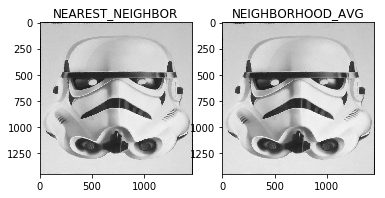

In [5]:
image_side_by_side([resp, resp_avg], ['NEAREST_NEIGHBOR', 'NEIGHBORHOOD_AVG'])

Na imagem a seguir é apresentada uma versão expandida da imagem original de forma a permitr uma melhor observação dos resultados de ambos os métodos.

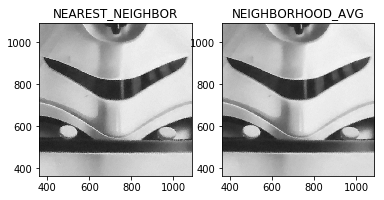

In [6]:
image_side_by_side([resp, resp_avg], ['NEAREST_NEIGHBOR', 'NEIGHBORHOOD_AVG'],
	[resp_avg.shape[0] / 4, 3 * resp_avg.shape[0] / 4],
	[resp_avg.shape[1] / 4, 3 * resp_avg.shape[1] / 4])

## Discussão

Ao comparar os resultados podemos verificar visualmente que os mesmos são bastante semelhantes contudo com uma diferença significativa em termos de tempo de processamento.
O método NEAREST_NEIGHBOR gastou 72,40 segundos ao passo que o método utilizou 104,13 segundos, o que representa uma diferença de 43,83% sobre o tempo do primeiro.